In [ ]:
import os
import sys

sys.path.append("..")  # Avoid error with importing of src
from src.utils_py.substr import generate_substrate, generate_calcite_itp, get_calcite_neighbors_list_numpy, get_calcite_neighbors_list
from src.utils_py.io.gro import read_gro
from src.utils_py.parser import parse_C6_C12

In [5]:
path = '../substrates/calcite/calcite_104_unitcell.gro'

In [6]:
# name = generate_substrate(path, 5, 5, 5)
name = generate_substrate(path, 20, 5, 4)

Possible substrate size 18.0x4.8x3.7
Substrate successfully created!


In [7]:
name

'calcite_104_9x3x3.gro'

In [8]:
0.002 * 5000000

10000.0

In [9]:
''.join([i for i in 'CCA1' if not i.isdigit()])

'CCA'

In [10]:
'{:>.2e}'.format(12.123044132)

'1.21e+01'

In [11]:
from itertools import combinations

for i, j in list(combinations([1, 2, 3], 2)):
    print(i, j)

1 2
1 3
2 3


In [12]:
path = '../substrates/calcite/gro/calcite_104_2x3x4.gro'
substr = read_gro(path)

In [13]:
neigh_dict = get_calcite_neighbors_list(substr)

Generating neighbors list


  0%|          | 33/7680 [00:00<03:44, 34.04it/s]


KeyboardInterrupt: 

In [8]:
neigh_dict_numpy = get_calcite_neighbors_list_numpy(substr)

100%|██████████| 7680/7680 [00:00<00:00, 1928762.03it/s]


Generating neighbors list


100%|██████████| 1536/1536 [00:00<00:00, 3163.77it/s]


In [9]:
neigh_dict == neigh_dict_numpy

True

In [11]:
os.path.split(os.path.split(path)[0])[0]

'../substrates/calcite'

In [9]:
substrate_itp = generate_calcite_itp(path)

100%|██████████| 25920/25920 [00:00<00:00, 2050981.19it/s]


Generating neighbors list


100%|██████████| 25920/25920 [00:04<00:00, 5254.79it/s]


In [13]:
substrate_itp

'calcite_104_1x4x1.itp'

In [34]:
freeze_substr = False
ansambel = 'npt'

assert (
    not freeze_substr or ansambel != "npt"
), "Can not run npt with freeze substr"

In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
time1, pot1, temp1, press1, box_x1, box_y1, box_z1 = np.loadtxt("../data/energy_1.xvg", comments=["@", "#"], unpack=True)

In [12]:
time100, pot100, temp100, press100, box_x100, box_y100, box_z100 = np.loadtxt("../data/energy_100.xvg", comments=["@", "#"], unpack=True)

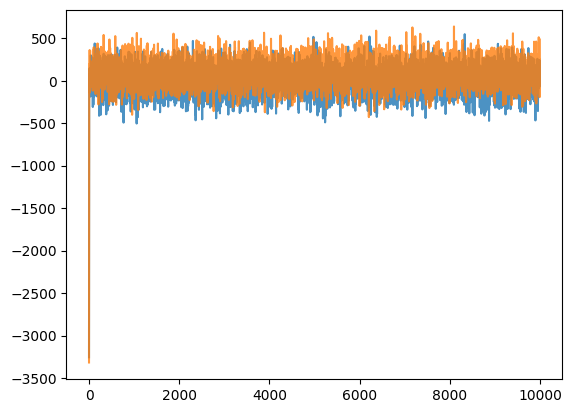

In [16]:
begin = 0
plt.plot(time1[begin:], press1[begin:], alpha=0.8)
plt.plot(time100[begin:], press100[begin:], alpha=0.8)
plt.show()

In [68]:
arr = np.arange(1, 11, dtype=int)
arr

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [69]:
mask = np.array([3, 4, 5])

In [75]:
np.argwhere((arr[mask] - 2) < 3).ravel()

array([0])

In [2]:
with open('../ff/trappe/trappe.top') as inp:
    text = inp.read()

In [6]:
parse_C6_C12(text, ['CA', 'OCA', 'CCA'])

{'CA': [0.00142, 2.52e-07],
 'OCA': [0.00203, 1.77e-06],
 'CCA': [0.00461, 1.44e-05]}

In [8]:
10000000 * 0.002

20000.0

---

In [1]:
import numpy as np
import MDAnalysis as mda
from tqdm import tqdm
import mdtraj as md
import sys

In [48]:
traj = md.load('../data/cal_dec_tip3p_center.xtc', top='../data/cal_dec_tip3p_center.gro')

In [57]:
len(traj.time.astype(int))

5001

In [62]:
10_000 % 300

100

In [ ]:
M = 10

In [53]:
chunk.time.astype(int)

array([10000])

In [19]:
block_lenght: float = 300
begin_time: float = 5_000
time: float = 10_000
timestep: float = 2
units: str = "ps"

assert units.lower() in ["ns", "ps"], "Wrong units format"
units = 1000 if units.lower() == "ns" else 1

N = int(time * units) // int(timestep * units) + 1
L = int((time - begin_time) * units) // int(block_lenght * units)
tau = int(block_lenght * units) // int(timestep * units)

start_frame = N - tau * L

In [20]:
start_frame

2601

In [3]:
for chunk in md.iterload('../data/cal_dec_tip3p_center.xtc', top='../data/cal_dec_tip3p_center.gro', chunk=tau, skip=start_frame):
    times = chunk.time.astype(int)
    print(chunk.time.astype(int), len(times))
    break

[  2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36
  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72
  74  76  78  80  82  84  86  88  90  92  94  96  98 100 102 104 106 108
 110 112 114 116 118 120 122 124 126 128 130 132 134 136 138 140 142 144
 146 148 150 152 154 156 158 160 162 164 166 168 170 172 174 176 178 180
 182 184 186 188 190 192 194 196 198 200] 100


In [3]:
import numpy as np
from tqdm import tqdm
import mdtraj as md
import matplotlib.pyplot as plt

import os
import sys

sys.path.append("..")  # Avoid error with importing of src

from src.utils_py.stat_ineff import get_numerical_density_profile, get_center_pbc, apply_pbc, get_statistical_inefficiency_RCA

In [5]:
residue_mask = chunk.top.select(f"resname DECAN")
positions = chunk.xyz[:, residue_mask, :]
box = chunk.unitcell_lengths[:, np.newaxis, :]

# Calculating and centering aroud center mass with relative to the PBC
center = get_center_pbc(positions, box)
positions -= center
positions += box / 2
positions = apply_pbc(positions, box)

In [14]:
axis, dens = get_numerical_density_profile(positions, box, 200)

In [15]:
len(axis)

200

In [16]:
axis /= 9
dens /= 3.0896 * 10

In [17]:
np.trapz(dens, axis)

0.4998925314712175

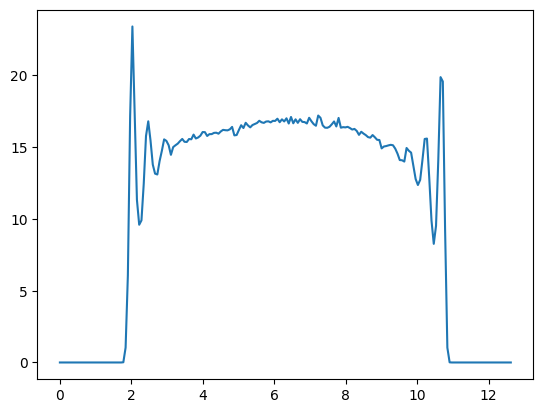

In [11]:
plt.plot(axis, dens)

In [61]:
H = 9
l, phi = 18.004 / H, 0.5
rho_bulk = 3.0896 * 10

# block_lenghts = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
block_lenghts = [8000, 9000, 10000]
# PHIs = []

for bl in block_lenghts:
    PHI = get_statistical_inefficiency_RCA(
        '../data/cal_dec_tip4p.xtc',
        '../data/cal_dec_tip4p.gro',
        rho_bulk,
        l,
        phi,
        H,
        'roll',
        'DECAN',
        200,
        block_lenght=bl,
        begin_time=5_000,
        time=40_000,
        timestep=2,
        display=False
    )

    PHIs.append(PHI)

100%|██████████| 4/4 [01:34<00:00, 23.55s/it]


X [135.88000488 137.9498291  137.51147461 ... 180.         180.
 141.70429038] 12.95935317072738
Y [132.71702013 132.79522871 130.72760906 128.38434462] 1.8020437661138893


100%|██████████| 3/3 [01:23<00:00, 27.68s/it]


X [148.4901123  149.86567998 139.83837891 ... 180.         180.
 141.70429038] 13.761288970580914
Y [133.63957723 131.02388467 127.84820654] 2.367998539020198


100%|██████████| 3/3 [01:31<00:00, 30.46s/it]

X [140.89306641 137.4534874  128.14123535 ... 180.         180.
 141.70429038] 13.229212586021667
Y [131.03308601 132.87107813 127.32586345] 2.306298621401813


In [62]:
block_lenghts = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

In [63]:
tau = np.array([35, 17, 11, 8, 7, 5, 5, 4, 3, 3])

In [25]:
Y = np.array([4.67527978879759, 3.672595302836527, 2.8022762311670824, 2.6240707370260625, 3.618539397524286, 1.8979680042298328, 2.2201292190023723, ])

In [26]:
X = np.array([12.847376874884809, 12.841816917507142, 12.870732834799009, 12.95935317072738, 12.847376874884809, 13.229212586021667, 12.847376874884809])

NameError: name 'block_lenghts' is not defined

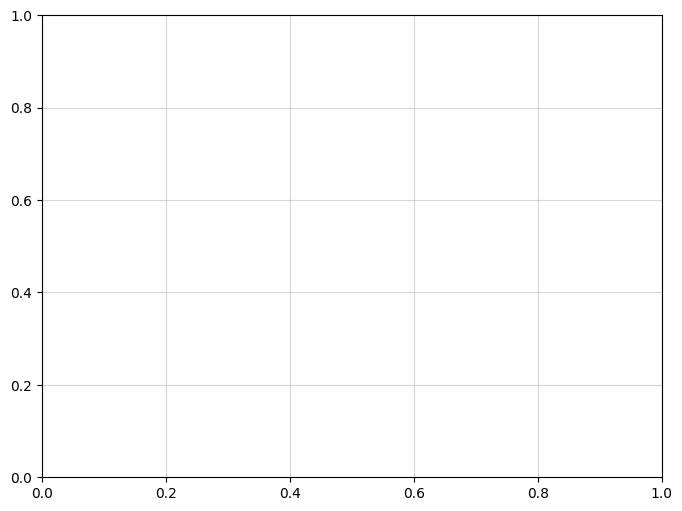

In [41]:
plt.figure(figsize=(8, 6))
plt.grid(alpha=0.5)

plt.hlines(1, block_lenghts[0] / 1000, block_lenghts[-1] / 1000, ls='--', colors='red')
plt.scatter(np.array(block_lenghts) / 1000, tau * Y/X)

plt.xlabel('tau, ns', fontsize=14)
plt.ylabel(r'$\tau \cdot \sigma(Y)_{\tau}/\sigma(X)$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(bottom=-0.1)
plt.show()

In [34]:
tau * Y / X

array([12.73682513,  4.86178245,  2.39497152,  1.6198776 ,  1.97159125,
        0.71733975,  0.86403989])

In [32]:
np.array(PHIs) / np.array(block_lenghts)

array([0.18195464, 0.1429936 , 0.10886234, 0.10124235, 0.14082795,
       0.07173397, 0.08640399])

In [13]:
PHIs

[181.95464468459863,
 285.98720309037486,
 326.5870250515743,
 404.9693997001826,
 704.1397307722264,
 430.40384872988034,
 604.8279226321034]

In [33]:
np.array(PHIs) * np.array([35, 17, 11, 8, 7, 5, 5]) / block_lenghts

array([6.36841256, 2.43089123, 1.19748576, 0.8099388 , 0.98579562,
       0.35866987, 0.43201994])

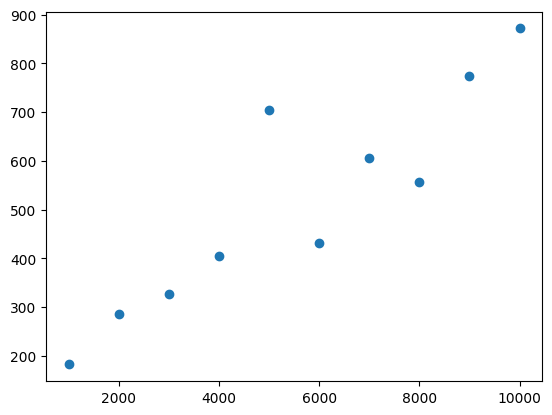

In [64]:
plt.scatter(block_lenghts, np.array(PHIs))

---

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
t1, en1 = np.loadtxt("../data/energy_T_393.xvg", comments=["@", "#"], unpack=True)
t2, en2 = np.loadtxt("../data/energy_2.5.xvg", comments=["@", "#"], unpack=True)

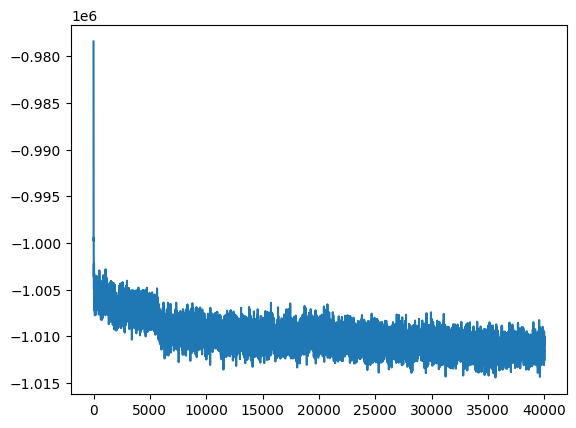

In [16]:
# begin = 5_000
# plt.plot(t1[begin:], en1[begin:])
plt.plot(t2, en2)

In [18]:
# t, en = np.loadtxt("/home/fluffymelon/PANDA_exp/scaling/calcite_decane_tip4p_sc_2.0_offset/energy.xvg", comments=["@", "#"], unpack=True)
t, en = np.loadtxt("/home/fluffymelon/PANDA_exp/scaling/calcite_decane_tip4p_sc_2.0_offset_0.2/energy.xvg", comments=["@", "#"], unpack=True)

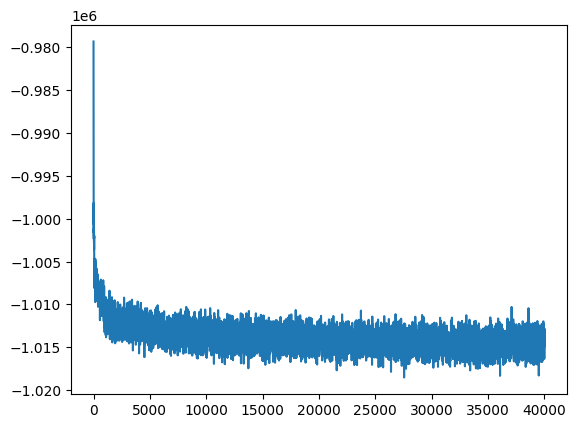

In [19]:
plt.plot(t, en)

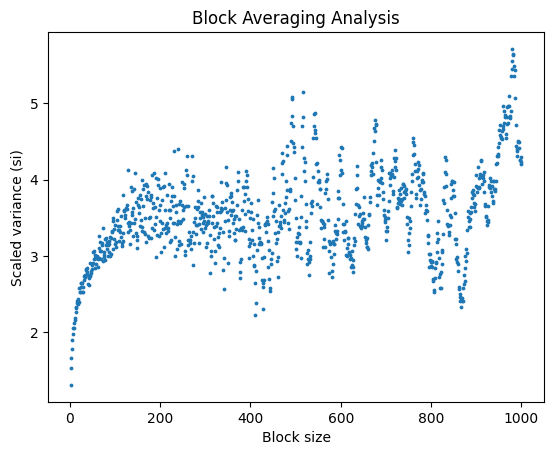

In [60]:
# Input array
begin = 5_000
x = en1[begin:] # Replace with your data

# Compute variance, mean, and length
v = np.var(x, ddof=1)  # ddof=1 for sample variance (like in R)
m = np.mean(x)
n = len(x)

si = []  # List to store the scaled variances
for t in range(2, 1001):  # Equivalent to seq(2, 1000)
    nblocks = n // t  # Number of blocks
    if nblocks > 0:
        # Create blocks of size `t`
        xg = np.split(x[:nblocks * t], nblocks)
        # Calculate mean of each block
        block_means = np.array([np.mean(block) for block in xg])
        # Variance of the block means
        v2 = np.sum((block_means - m) ** 2) / nblocks
        # Compute scaled variance and append
        si.append(t * v2 / v)
    else:
        break

# Plot the result
plt.scatter(range(2, 2 + len(si)), si, s=3)
plt.xlabel('Block size')
plt.ylabel('Scaled variance (si)')
plt.title('Block Averaging Analysis')
plt.show()


---

In [2]:
import mdtraj as md
import numpy as np
from tqdm import tqdm
import sys
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize, Bounds
from itertools import combinations

sys.path.append("..")  # Avoid error with importing of src
from src.utils_py.utils import get_center_pbc, apply_pbc, get_numerical_density_profile
from src.utils_py.profile_approx import _profile_approx_alpha_from_array, L1, grad_L1
from src.utils_py.auxil import *

In [3]:
trajectory_file = '/home/fluffymelon/PANDA_exp/scaling/production/calcite_decane_tip4p_sc_2.0_offset_0.2/cal_dec_tip4p.xtc'
topology_file = '/home/fluffymelon/PANDA_exp/scaling/production/calcite_decane_tip4p_sc_2.0_offset_0.2/cal_dec_tip4p.gro'
residue = 'DECAN'
H = 9
l, phi = 18.004 / H, 0.5
rho_bulk = 3.0896 * 10
interface_type = 'roll'
sl=200
block_lenght=5_000
begin_time=0_000
time=40_000
timestep=2
units=1
samples=1
display=False

N = int(time * units) // int(timestep * units) + 1
L = int((time - begin_time) * units) // int(block_lenght * units)
tau = int(block_lenght * units) // int(timestep * units)
start_frame = N - tau * L

axises = []
denses = []
angles = []
delta = []

for chunk in tqdm(
    md.iterload(trajectory_file, top=topology_file, chunk=tau, skip=start_frame),
    total=L,
):
    residue_mask = chunk.top.select(f"resname {residue}")
    positions = chunk.xyz[:, residue_mask, :]
    box = chunk.unitcell_lengths[:, np.newaxis, :]

    # Calculating and centering aroud center mass with relative to the PBC
    center = get_center_pbc(positions, box)
    positions -= center
    positions += box / 2
    positions = apply_pbc(positions, box)

    # Calculating contact angle for each frame
    for i in range(tau):
        axis_i, dens_i = get_numerical_density_profile(
            positions[i, :, :], box[i, :, :], sl, center=True
        )
        # _, _, best_i = _profile_approx_alpha_from_array(
        #     dens_i, axis_i, rho_bulk, l, phi, H, interface_type, samples=samples, display=display
        # )

        # angles.append(np.rad2deg(best_i['theta']))
        # delta.append(best_i['delta'])
        axises.append(axis_i)
        denses.append(dens_i)

angles = np.array(angles)
delta = np.array(delta)
axises = np.array(axises)
denses = np.array(denses)

100%|██████████| 8/8 [02:54<00:00, 21.77s/it]


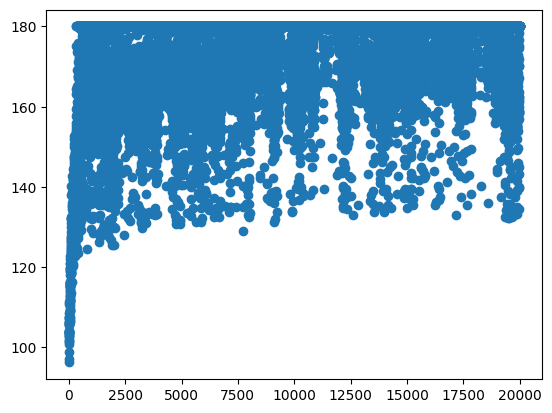

In [4]:
plt.scatter(np.arange(len(angles)), angles)

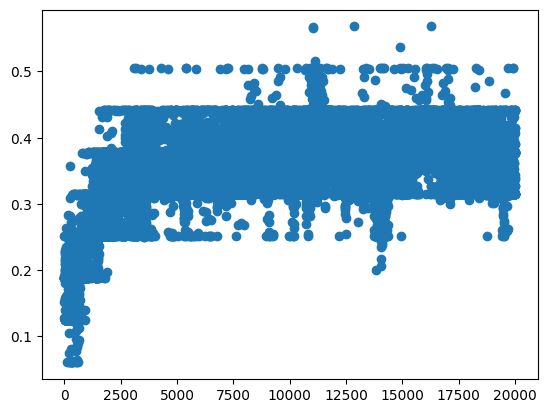

In [5]:
plt.scatter(np.arange(len(delta)), delta * 9)

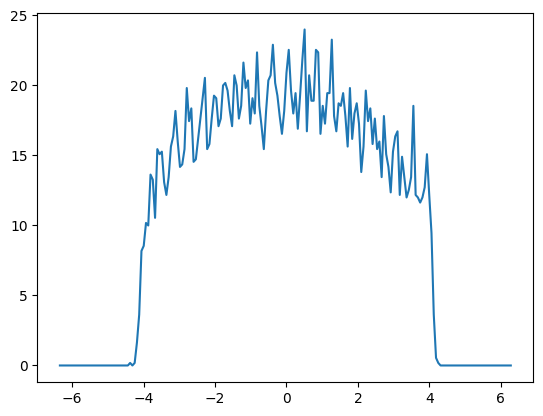

In [6]:
i = 10000
plt.plot(axises[i, :], denses[i, :])

  0%|          | 0/20 [00:00<?, ?it/s]

{'theta': 2.0750824385867666, 'delta': 0.008248785669464126, 'fun': 2.4285319115156034}
0.4998925314712249


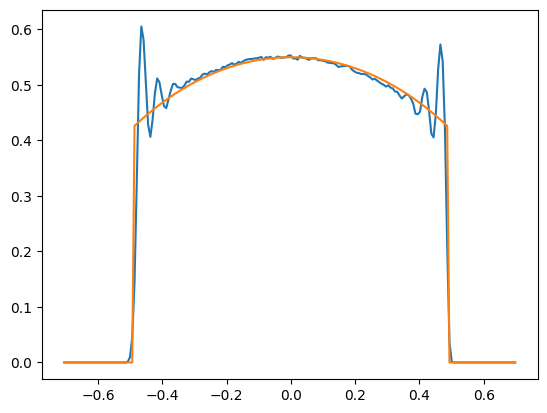

  5%|▌         | 1/20 [00:00<00:06,  2.92it/s]

{'theta': 2.251811324102118, 'delta': 0.01378008024930585, 'fun': 1.8640941067898478}
0.49989253147122337


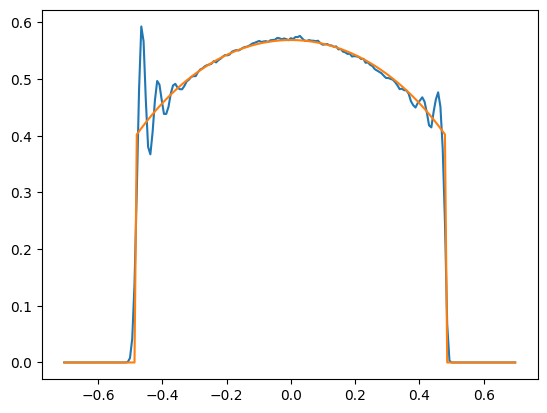

 10%|█         | 2/20 [00:00<00:04,  3.81it/s]

{'theta': 2.3027648699688257, 'delta': 0.013780649519211931, 'fun': 2.6127198491439607}
0.49989253147122004


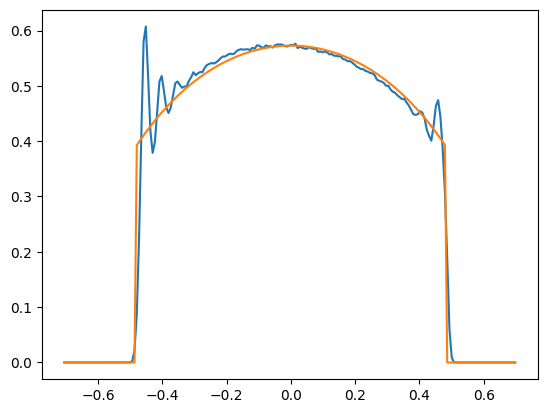

 15%|█▌        | 3/20 [00:00<00:03,  4.60it/s]

{'theta': 2.1960604893450837, 'delta': 0.02083105340018092, 'fun': 2.1685242525745467}
0.49989253147122015


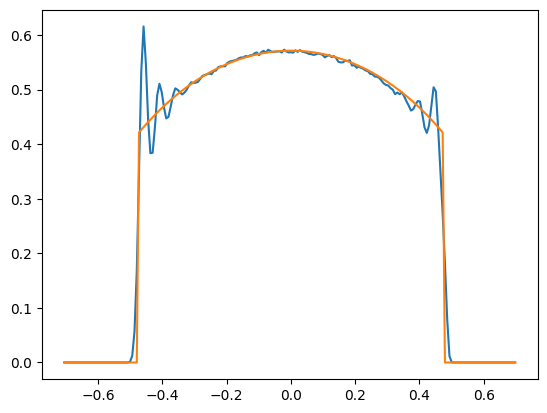

 20%|██        | 4/20 [00:00<00:03,  5.02it/s]

{'theta': 2.1998244986305813, 'delta': 0.020826887828880123, 'fun': 2.3611759723475747}
0.49989253147121987


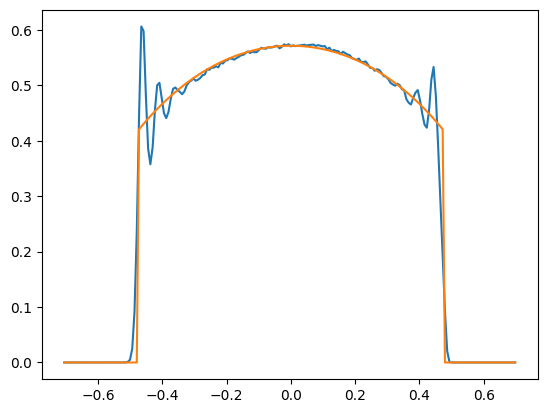

 25%|██▌       | 5/20 [00:01<00:02,  5.39it/s]

{'theta': 2.253463764661963, 'delta': 0.020827916112283216, 'fun': 2.423211012333648}
0.4998925314712189


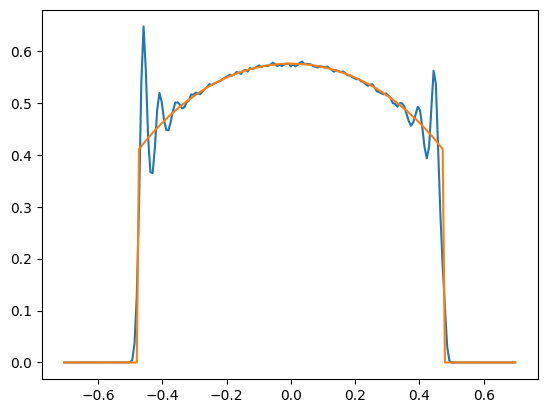

 30%|███       | 6/20 [00:01<00:02,  5.49it/s]

{'theta': 2.2551725938628824, 'delta': 0.020826684053988374, 'fun': 2.7657687680127907}
0.49989253147121826


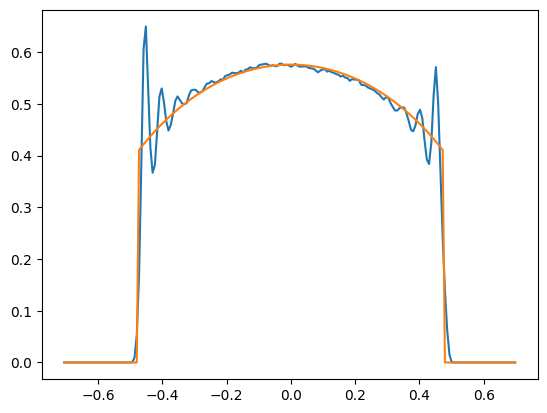

 35%|███▌      | 7/20 [00:01<00:02,  5.66it/s]

{'theta': 2.2734459910116485, 'delta': 0.021907131637094582, 'fun': 2.5468092426650575}
0.4998925314712183


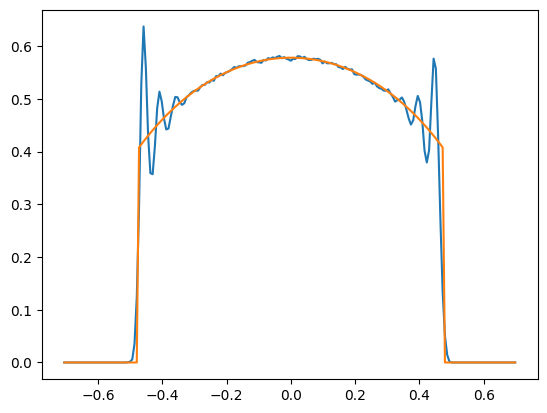

 40%|████      | 8/20 [00:01<00:02,  5.84it/s]

{'theta': 2.27279796042627, 'delta': 0.020826666242434025, 'fun': 2.5099230132833066}
0.4998925314712175


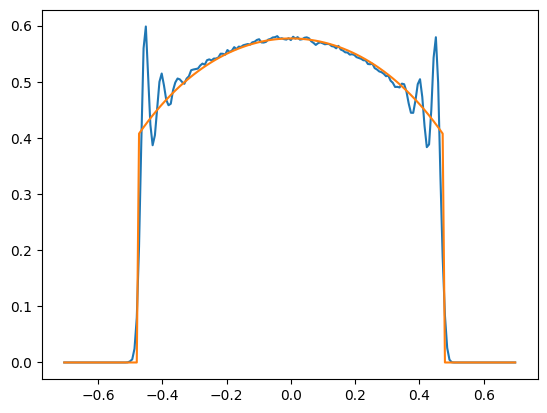

 45%|████▌     | 9/20 [00:01<00:01,  5.87it/s]

{'theta': 2.190837142228001, 'delta': 0.027873397901758377, 'fun': 2.8823973287177456}
0.49989253147121615


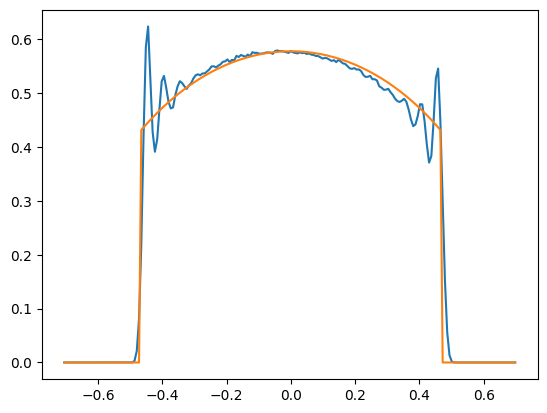

 50%|█████     | 10/20 [00:01<00:01,  5.58it/s]

{'theta': 2.2223499772822466, 'delta': 0.027874668153657564, 'fun': 2.5317863728435563}
0.49989253147121676


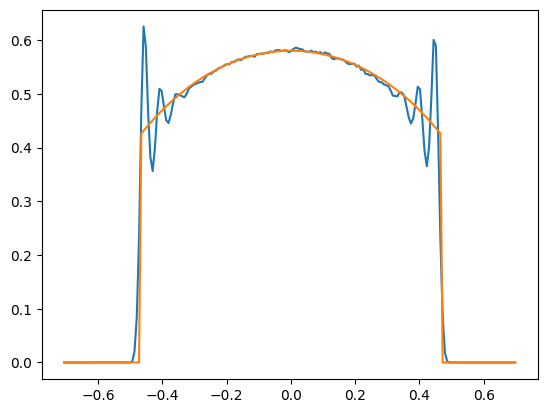

 55%|█████▌    | 11/20 [00:02<00:01,  5.62it/s]

{'theta': 2.2104186445547187, 'delta': 0.027873345781948382, 'fun': 2.472303129653504}
0.499892531471216


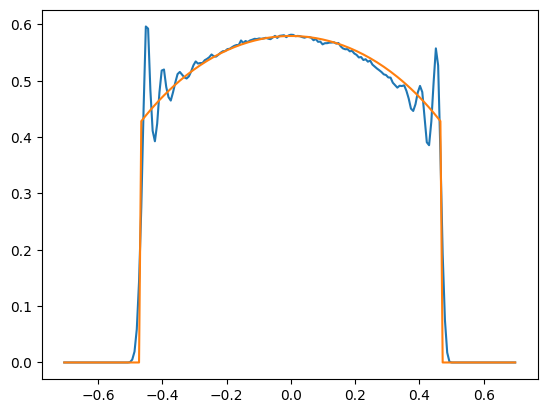

 60%|██████    | 12/20 [00:02<00:01,  5.54it/s]

{'theta': 2.214527212804361, 'delta': 0.027878092835341838, 'fun': 2.5417410170643526}
0.4998925314712155


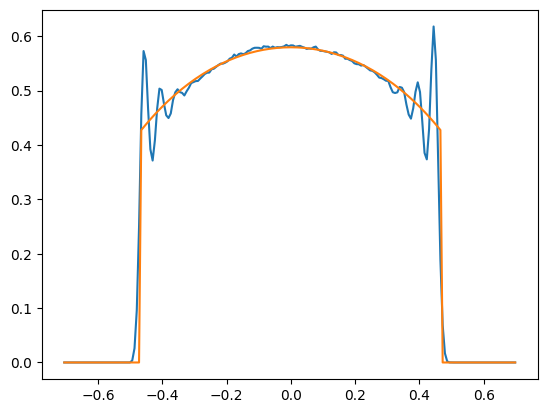

 65%|██████▌   | 13/20 [00:02<00:01,  5.79it/s]

{'theta': 2.2143220878453156, 'delta': 0.027873613571120136, 'fun': 2.856314582273291}
0.49989253147121526


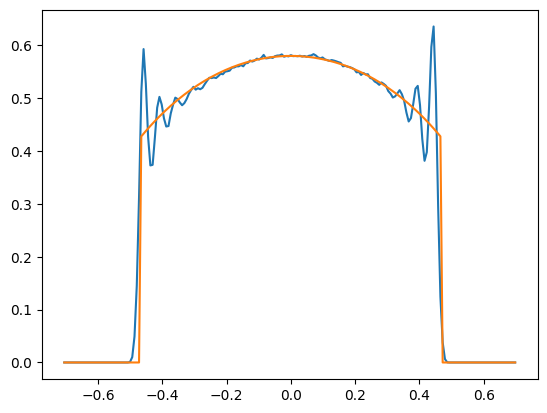

 70%|███████   | 14/20 [00:02<00:01,  5.79it/s]

{'theta': 2.2229240931307213, 'delta': 0.027873399684856064, 'fun': 2.7483382717996427}
0.4998925314712148


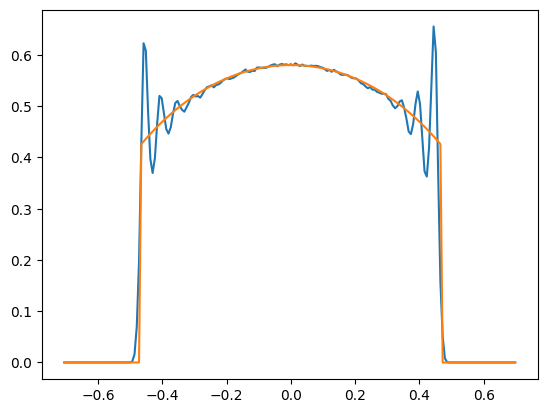

 75%|███████▌  | 15/20 [00:02<00:00,  5.60it/s]

{'theta': 2.2382401636478417, 'delta': 0.02787333293713399, 'fun': 2.458784690293329}
0.4998925314712144


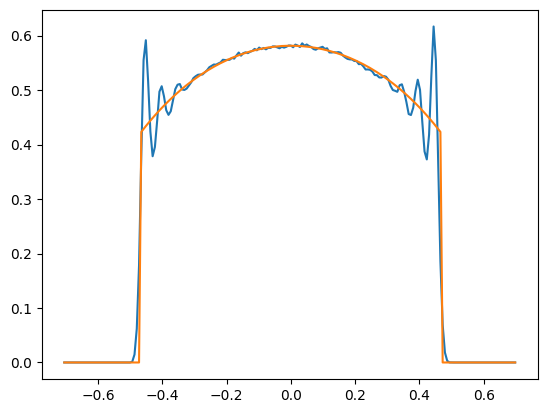

 80%|████████  | 16/20 [00:02<00:00,  5.72it/s]

{'theta': 2.2379083935385697, 'delta': 0.027873334827661096, 'fun': 2.686298153462287}
0.49989253147121465


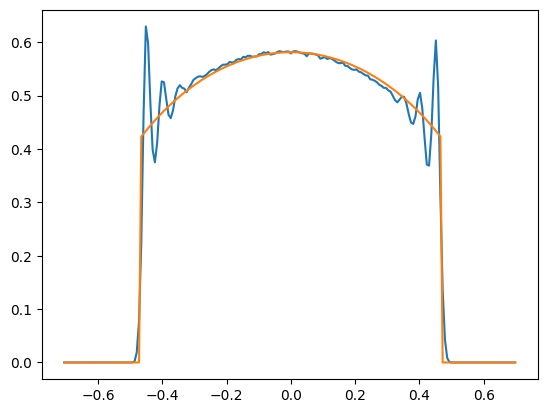

 85%|████████▌ | 17/20 [00:03<00:00,  5.78it/s]

{'theta': 2.198255904603484, 'delta': 0.0278826681872345, 'fun': 3.0386400368951283}
0.49989253147121454


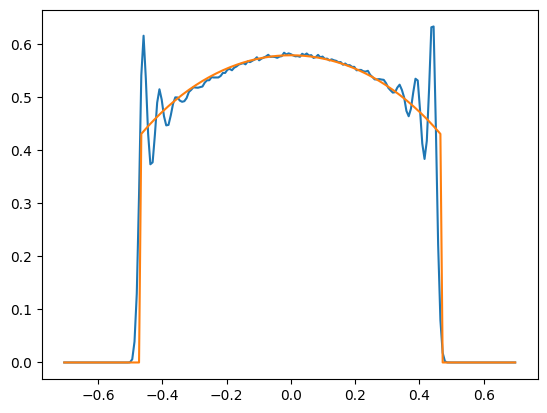

 90%|█████████ | 18/20 [00:03<00:00,  5.47it/s]

{'theta': 2.218785483844703, 'delta': 0.02787455382063925, 'fun': 2.7061143581936484}
0.4998925314712144


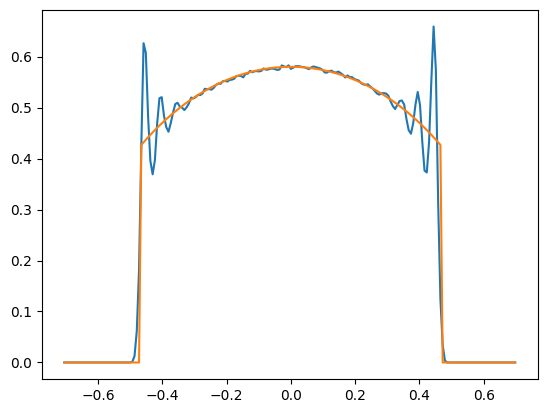

 95%|█████████▌| 19/20 [00:03<00:00,  5.13it/s]

{'theta': 2.328549957122102, 'delta': 0.024516857077789625, 'fun': 3.2189859913647543}
0.49989253147121354


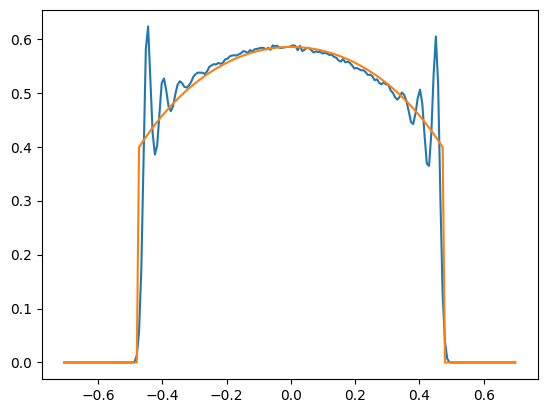

100%|██████████| 20/20 [00:03<00:00,  5.38it/s]


In [4]:
block_lenght = 1000

mean_denses = []
mean_axises = []
angles_trunc = []
delta_trunc = []
for i in tqdm(range(len(denses)%block_lenght, len(denses), block_lenght)):
    mean_dens = np.mean(denses[i:i+block_lenght, :], axis=0)
    mean_axis = np.mean(axises[i:i+block_lenght, :], axis=0)

    mean_denses.append(mean_dens)
    mean_axises.append(mean_axis)

    # real_axis, real_dens, best_i, res = _profile_approx_alpha_from_array(
    #     mean_dens, mean_axis, rho_bulk, l, phi, H, interface_type, display=True
    # )

    real_axis, real_dens, best_i = _profile_approx_alpha_from_array(
        mean_dens, mean_axis, rho_bulk, l, phi, H, interface_type, samples=3, display=display
    )
    print(best_i)

    print(np.trapz(real_dens, real_axis))
    plt.plot(real_axis, real_dens)
    plt.plot(real_axis, rho_roll_alpha(real_axis, 18.004 / 9, 0.5, best_i['theta'], best_i['delta']))
    plt.show()

    # print(best_i['delta'] * 9)
    angles_trunc.append(np.rad2deg(best_i['theta']))
    delta_trunc.append(best_i['delta'])

angles_trunc = np.array(angles_trunc)
delta_trunc = np.array(delta_trunc)
mean_denses = np.array(mean_denses)
mean_axises = np.array(mean_axises)

In [8]:
i = -2
dens_test = mean_denses[i]
axis_test = mean_axises[i]

axis_norm, dens_norm, best = _profile_approx_alpha_from_array(
    dens_test, axis_test, 3.0896 * 10, 18.004 / 9, 0.5, 9.0, interface_type, samples=4, display=False
)

In [9]:
arr = np.column_stack((axis_norm, dens_norm))
header = "z, dens"
np.savetxt("../profile_scale_0.7_time_38_ns.txt", arr, delimiter="\t", header=header)
# np.savetxt(args.output_file, output_data, delimiter="\t"comments=header)

In [10]:
i = -1
dens_test = mean_denses[i]
axis_test = mean_axises[i]

axis_norm, dens_norm, best = _profile_approx_alpha_from_array(
    dens_test, axis_test, 3.0896 * 10, 18.004 / 9, 0.5, 9.0, interface_type, samples=1, display=True
)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.16478D+01    |proj g|=  7.85398D-01

At iterate    1    f=  4.16478D+01    |proj g|=  7.85398D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1      3      2     0     2   7.854D-01   4.165D+01
  F =   41.647800635565588     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [ ]:
{'theta': 2.3090172261105875, 'delta': 0.041966665459194884}

In [9]:
norm = []
thetas = np.linspace(np.deg2rad(91), np.deg2rad(180), 100)
for th in thetas:
    norm.append(np.sum(
        np.abs(rho_roll_alpha(mean_axises[i, :] / 9, 18.004 / 9, 0.5, th, delta_trunc[i]) - mean_denses[i, :] / (3.0896 * 10))
    ))

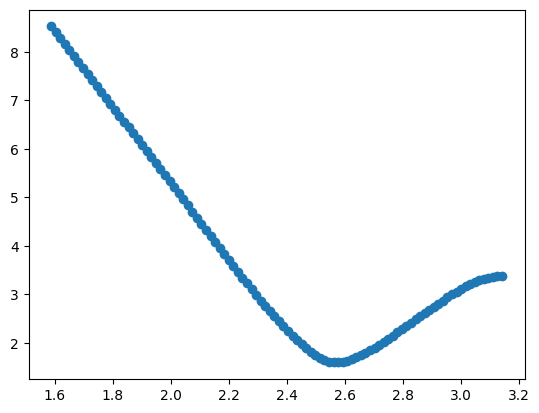

In [10]:
plt.scatter(thetas, norm)

In [13]:
grad_norm_theta = []
grad_norm_delta = []
thetas = np.linspace(np.deg2rad(95), np.deg2rad(170), 100)
for th in thetas:
    grad = np.sum(
        np.sign(rho_roll_alpha(mean_axises[i, :] / 9, 18.004 / 9, 0.5, th, delta_trunc[i]) - mean_denses[i, :] / (3.0896 * 10)) * grad_rho_roll_alpha(mean_axises[i, :] / 9, 18.004 / 9, 0.5, th, delta_trunc[i]),
        axis=1
    )

    grad_norm_theta.append(grad[0])
    grad_norm_delta.append(grad[1])

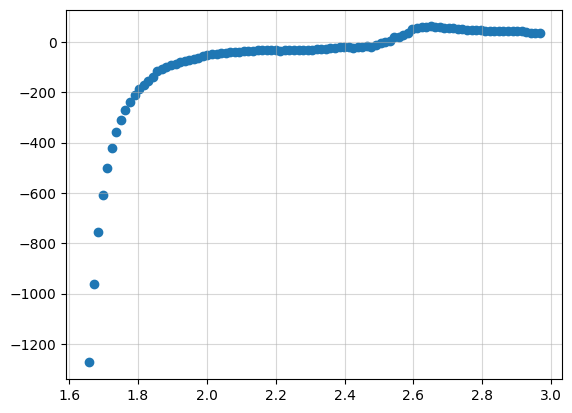

In [15]:
plt.grid(alpha=0.5)

plt.scatter(thetas, grad_norm_theta)
# plt.scatter(thetas, grad_norm_delta)

In [23]:
norm = []
delta = np.linspace(0, 0.49, 100)
for d in delta:
    norm.append(np.sum(
        np.abs(rho_roll_alpha(mean_axises[i, :] / 9, 18.004 / 9, 0.5, np.deg2rad(angles_trunc[i]), d) - mean_denses[i, :] / (3.0896 * 10))
    ))

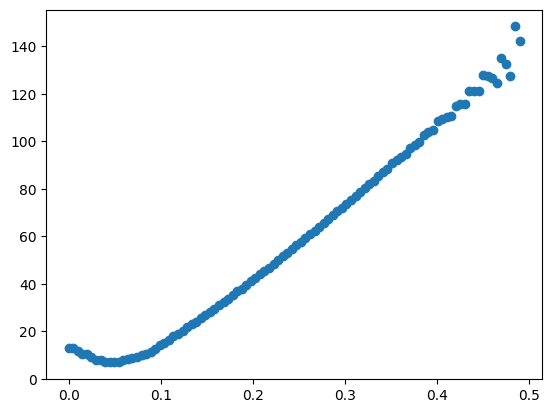

In [24]:
plt.scatter(delta, norm)

In [51]:
norm = []
i=9
for v in res.allvecs:
    norm.append(np.sum(
        np.abs(rho_roll_alpha(mean_axises[i, :] / 9, 18.004 / 9, 0.5, v[0], v[1]) - mean_denses[i, :] / (3.0896 * 10))
    ))

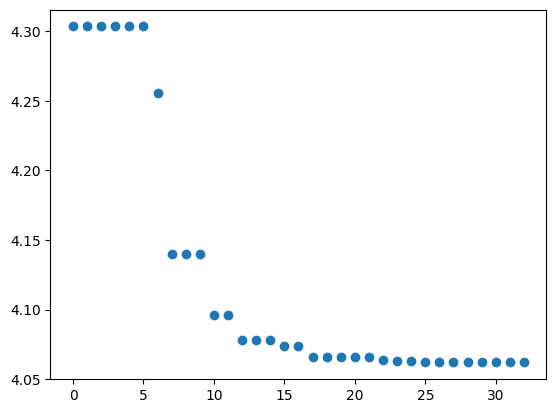

In [53]:
begin = 5
plt.scatter(range(len(res.allvecs)-begin), norm[begin:])

In [32]:
(delta_trunc[i] + 0.03)

0.036739818572998045

In [40]:
i = 9

np.sum(
    np.abs(rho_roll_alpha(mean_axises[i, :] / 9, 18.004 / 9, 0.5, np.deg2rad(135), delta_trunc[i] + 0.02) - mean_denses[i, :] / (3.0896 * 10))
)

2.1032381273240217

In [41]:
i = 9

np.sum(
    np.abs(rho_roll_alpha(mean_axises[i, :] / 9, 18.004 / 9, 0.5, np.deg2rad(angles_trunc[i]), delta_trunc[i]) - mean_denses[i, :] / (3.0896 * 10))
)

4.0619587405626625

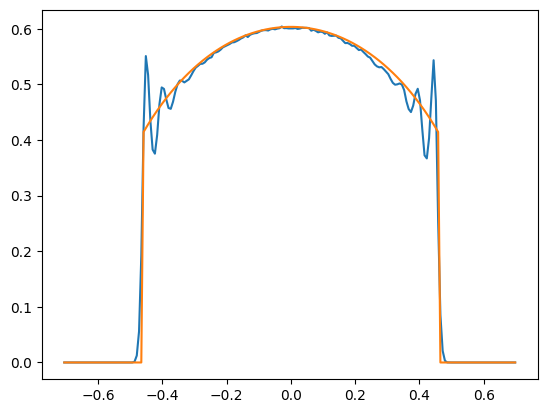

In [39]:
i = 9
plt.plot(mean_axises[i, :] / 9, mean_denses[i, :] / (3.0896 * 10))
plt.plot(mean_axises[i, :] / 9, rho_roll_alpha(mean_axises[i, :] / 9, 18.004 / 9, 0.5, np.deg2rad(135), delta_trunc[i] + 0.02))

In [7]:
angles_trunc_offset = angles_trunc.copy()

In [8]:
angles_trunc_offset

array([132.67933149, 147.06747811, 139.27139384, 140.16566689,
       140.77133175, 132.35620991, 138.67957079, 138.01583689,
       138.41557895, 138.35852059])

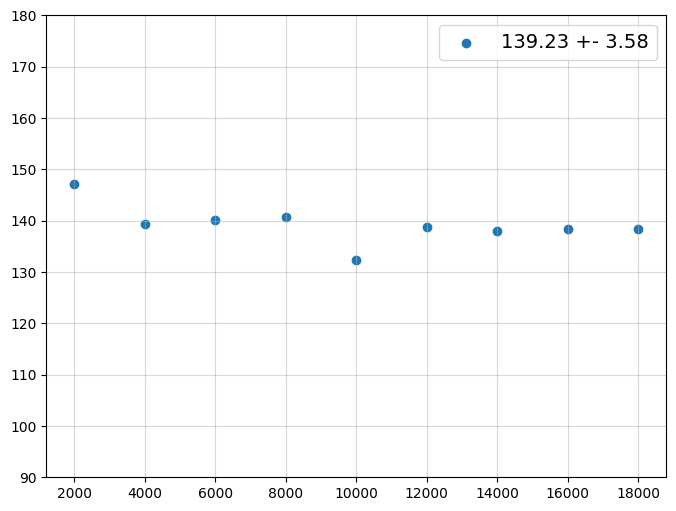

In [9]:
plt.figure(figsize=(8, 6))
plt.grid(alpha=0.5)

begin = 1
plt.scatter(range(len(denses)%block_lenght, len(denses), block_lenght)[begin:], angles_trunc_offset[begin:], label='{:.2f} +- {:.2f}'.format(np.mean(angles_trunc_offset[begin:]), np.std(angles_trunc_offset[begin:])))
plt.legend(fontsize=14)
plt.ylim(90, 180)
plt.show()

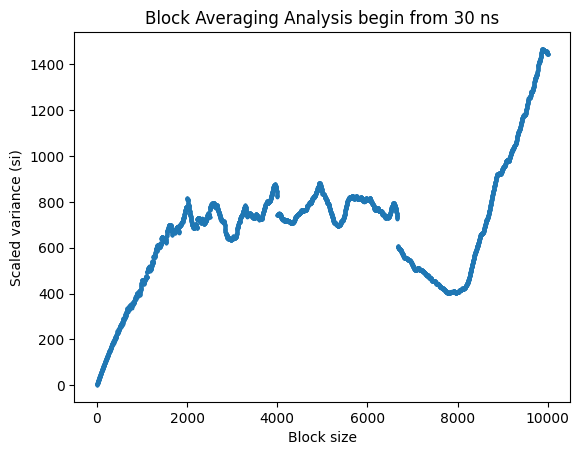

In [12]:
# Input array
begin = 0 // timestep // block_lenght
x = angles_trunc[begin:]

# Compute variance, mean, and length
v = np.var(x, ddof=1)  # ddof=1 for sample variance (like in R)
m = np.mean(x)
n = len(x)

si = []  # List to store the scaled variances
for t in range(2, 10001):  # Equivalent to seq(2, 1000)
    nblocks = n // t  # Number of blocks
    if nblocks > 0:
        # Create blocks of size `t`
        xg = np.split(x[:nblocks * t], nblocks)
        # Calculate mean of each block
        block_means = np.array([np.mean(block) for block in xg])
        # Variance of the block means
        v2 = np.sum((block_means - m) ** 2) / nblocks
        # Compute scaled variance and append
        si.append(t * v2 / v)
    else:
        break

# Plot the result
plt.scatter(range(2, 2 + len(si)), si, s=3)
plt.xlabel('Block size')
plt.ylabel('Scaled variance (si)')
plt.title('Block Averaging Analysis begin from 30 ns')
plt.show()


In [1]:
axises = np.array(axises)
denses = np.array(denses)

NameError: name 'np' is not defined

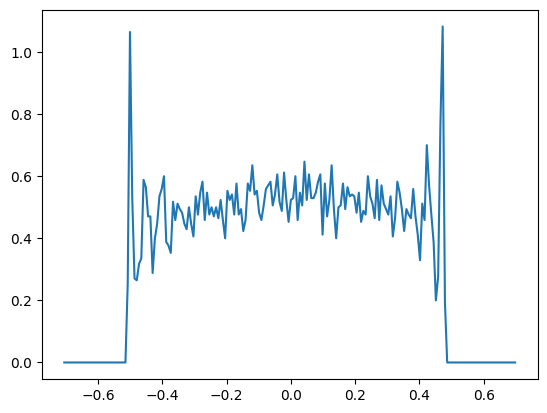

In [128]:
plt.plot(axises[-1], denses[-1, :])

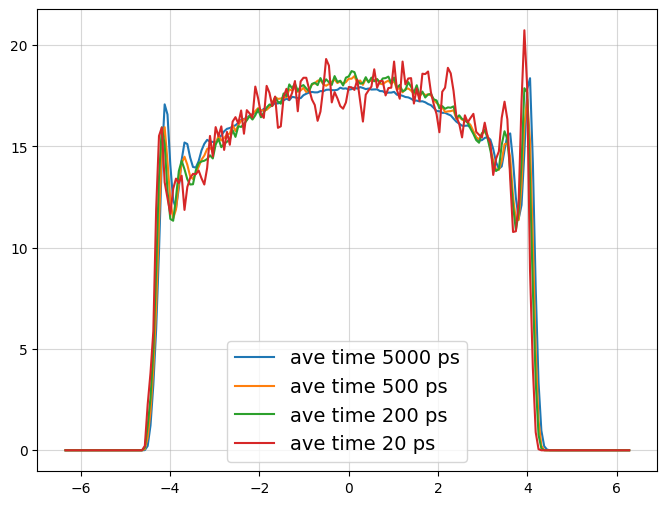

In [94]:
plt.figure(figsize=(8, 6))
plt.grid(alpha=0.5)

for begin in []:
    plt.plot(np.mean(axises[begin:], axis=0), np.mean(denses[begin:], axis=0), label=f'ave time {(2500 - begin) * 2} ps')

plt.legend(fontsize=14)

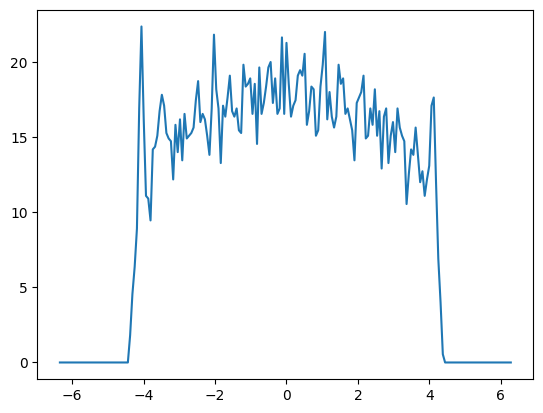

In [80]:
plt.plot(axises[1], denses[1])

---

In [101]:
def project_gradient_on_tangent_plane(fx, fy):
    """
    Projects the gradient vectors G = (fx, fy, 0) onto the tangent plane defined by
    tangent vectors v_x and v_y for a grid of points.

    Parameters:
        fx: np.ndarray - 2D array of partial derivatives of f with respect to x.
        fy: np.ndarray - 2D array of partial derivatives of f with respect to y.

    Returns:
        tuple of np.ndarray: Three 2D arrays (u, v, w) representing the components of
        the projected gradient vectors in the 3D space.
    """
    # Ensure fx and fy are 2D arrays
    assert fx.shape == fy.shape, "fx and fy must have the same shape"

    # Get the shape of the input grid
    shape = fx.shape

    # Initialize arrays for the projected gradient components
    u = np.zeros(shape)
    v = np.zeros(shape)
    w = np.zeros(shape)

    # Iterate over each grid point to compute the projection
    for i in range(shape[0]):
        for j in range(shape[1]):
            # Tangent vectors at each grid point
            v_x = np.array([1, 0, fx[i, j]])  # Tangent vector along x
            v_y = np.array([0, 1, fy[i, j]])  # Tangent vector along y

            # Gradient vector at the grid point
            # G = -np.array([fx[i, j], fy[i, j], 0])

            # # Compute the Gram matrix (Gij = vi \cdot vj)
            # G_matrix = np.array([
            #     [np.dot(v_x, v_x), np.dot(v_x, v_y)],
            #     [np.dot(v_y, v_x), np.dot(v_y, v_y)]
            # ])

            # # Compute the right-hand side vector (dot products of G with v_x and v_y)
            # rhs = np.array([
            #     np.dot(G, v_x),
            #     np.dot(G, v_y)
            # ])

            # # Solve for the coefficients a and b
            # coeffs = np.linalg.solve(G_matrix, rhs)
            # a, b = coeffs
            detom = 1 + fx[i, j]**2 + fy[i, j]**2

            a = - fx[i, j] * (1 + 2 * fy[i, j]**2) / detom
            b = - fy[i, j] * (1 + 2 * fx[i, j]**2) / detom

            # Compute the projection of G onto the tangent plane
            G_proj = a * v_x + b * v_y

            # Store the components of the projected gradient
            u[i, j], v[i, j], w[i, j] = G_proj

    return u, v, w

In [110]:
i = -1
dens_test = mean_denses[i]
axis_test = mean_axises[i]

axis_norm, dens_norm, best = _profile_approx_alpha_from_array(
    dens_test, axis_test, 3.0896 * 10, 18.004 / 9, 0.5, 9.0, interface_type, samples=1, display=True
)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.14682D+01    |proj g|=  2.00000D-01

At iterate    1    f=  5.72876D+00    |proj g|=  7.55431D-01

At iterate    2    f=  5.05058D+00    |proj g|=  6.30718D-01

At iterate    3    f=  4.65800D+00    |proj g|=  4.90000D-01

At iterate    4    f=  4.38625D+00    |proj g|=  4.84719D-01

At iterate    5    f=  3.50121D+00    |proj g|=  4.81466D-01

At iterate    6    f=  3.48036D+00    |proj g|=  4.18585D-01

At iterate    7    f=  3.44206D+00    |proj g|=  3.95876D-01

At iterate    8    f=  2.83664D+00    |proj g|=  1.28622D+00

At iterate    9    f=  2.75607D+00    |proj g|=  3.16888D-01

At iterate   10    f=  2.75498D+00    |proj g|=  4.75300D-01

At iterate   11    f=  2.75477D+00    |proj g|=  6.01929D-02

At iterate   12    f=  2.75476D+00    |proj g|=  4.75224D-01

At iterate   13    f=  2.7

In [117]:
# Define parameters for the demonstration
z = axis_norm
dens = dens_norm
l = 18.004 / 9
phi = 0.5

# Define the grid for plotting
N = 10
theta_vals = np.linspace(np.pi/2+0.02, np.pi, N)
delta_vals = np.linspace(0, 0.1, N)
Theta, Delta = np.meshgrid(theta_vals, delta_vals)

# Compute L1 values on the grid
L1_values = np.zeros_like(Theta)
for i in range(Theta.shape[0]):
    for j in range(Theta.shape[1]):
        L1_values[i, j] = L1(
            [Theta[i, j], Delta[i, j]], z, dens, l, phi, rho_roll_alpha
        )

# Compute gradients for each grid point
Grad_Theta = np.zeros_like(Theta)
Grad_Delta = np.zeros_like(Delta)
for i in range(Theta.shape[0]):
    for j in range(Theta.shape[1]):
        grad = grad_L1(
            [Theta[i, j], Delta[i, j]], z, dens, l, phi, rho_roll_alpha, grad_rho_roll_alpha
        )
        Grad_Theta[i, j] = grad[0]
        Grad_Delta[i, j] = grad[1]

u, v, w = project_gradient_on_tangent_plane(Grad_Theta, Grad_Delta)

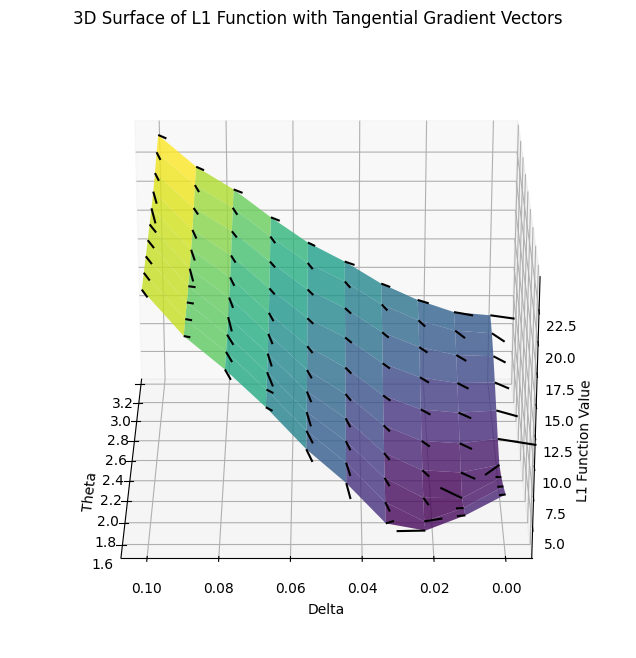

In [120]:
# Plot the 3D surface of L1 function
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(Theta, Delta, L1_values, cmap="viridis", alpha=0.8)
# fig.colorbar(surf, label="L1 Function Value")

# Add quiver plot for tangential gradients
quiver_scale = 0.3  # Scale for arrows in 3D
ax.quiver(
    Theta, Delta, L1_values,  # Base of the arrows starts at the surface
    u, v, w,  # Tangential gradient vectors
    color='black', length=quiver_scale, normalize=True, arrow_length_ratio=0
)

ax.set_title("3D Surface of L1 Function with Tangential Gradient Vectors")
ax.set_xlabel("Theta")
ax.set_ylabel("Delta")
ax.set_zlabel("L1 Function Value")
# Set the view angle to rotate around Z-axis
ax.view_init(elev=25, azim=-180)  # Elevation = 30 degrees, Azimuth = 45 degrees

plt.show()

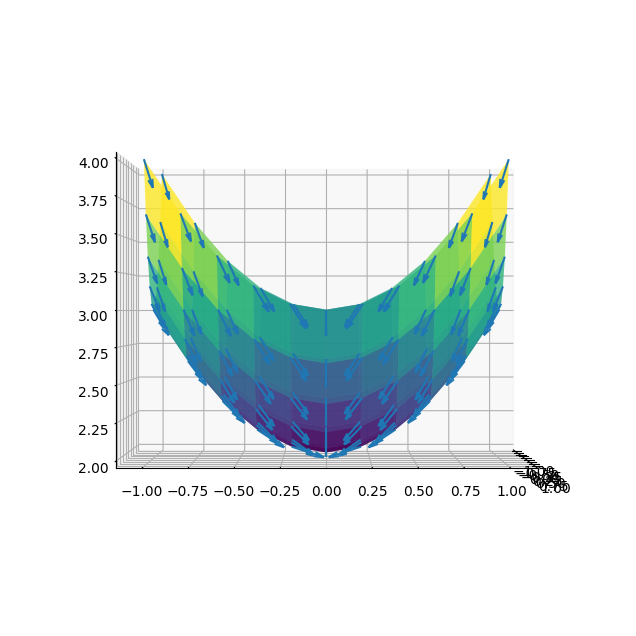

In [115]:
# Example usage
x, y = np.meshgrid(np.linspace(-1, 1, 11),
                   np.linspace(-1, 1, 11))

z = 2 + x**2 + y**2

# Example function: f(x, y) = x^2 + y^2
fx = 2 * x  # Partial derivative w.r.t. x
fy = 2 * y  # Partial derivative w.r.t. y

u, v, w = project_gradient_on_tangent_plane(fx, fy)

fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(projection='3d')

ax.plot_surface(x, y, z, cmap="viridis", alpha=0.8)

ax.quiver(x, y, z, u, v, w, length=0.2, normalize=True)
ax.view_init(elev=0, azim=0)  # Elevation = 30 degrees, Azimuth = 45 degrees
plt.show()

In [23]:
w

array([[-0.88888889, -0.83333333, -0.8       , -0.83333333, -0.88888889],
       [-0.83333333, -0.66666667, -0.5       , -0.66666667, -0.83333333],
       [-0.8       , -0.5       ,  0.        , -0.5       , -0.8       ],
       [-0.83333333, -0.66666667, -0.5       , -0.66666667, -0.83333333],
       [-0.88888889, -0.83333333, -0.8       , -0.83333333, -0.88888889]])

In [5]:
arr = [
[1,    11.60  ,0.05],
[1,    11.60  ,0.15],
[1,    11.60  ,0.25],
[1,    11.60  ,0.35],
[2,    5.80	,0.05],
[2,    5.80	,0.15],
[2,    5.80	,0.25],
[2,    5.80	,0.35],
[2,    5.80	,0.45],
[2,    5.80	,0.55],
[2,    5.80	,0.65],
[3,    3.87	,0.05],
[3,    3.87	,0.15],
[3,    3.87	,0.25],
[3,    3.87	,0.35],
[3,    3.87	,0.45],
[3,    3.87	,0.55],
[3,    3.87	,0.65],
[3,    3.87	,0.75],
[3,    3.87	,0.85],
[4,    2.90	,0.05],
[4,    2.90	,0.15],
[4,    2.90	,0.25],
[4,    2.90	,0.35],
[4,    2.90	,0.45],
[4,    2.90	,0.55],
[4,    2.90	,0.65],
[4,    2.90	,0.75],
[4,    2.90	,0.85],
[4,    2.90	,0.95],
[4,    2.90	,1.05]
]

In [6]:
for i in arr:
    print(f'({i[0]}, {i[1]}, {i[2]})', end=', ')

(1, 11.6, 0.05), (1, 11.6, 0.15), (1, 11.6, 0.25), (1, 11.6, 0.35), (2, 5.8, 0.05), (2, 5.8, 0.15), (2, 5.8, 0.25), (2, 5.8, 0.35), (2, 5.8, 0.45), (2, 5.8, 0.55), (2, 5.8, 0.65), (3, 3.87, 0.05), (3, 3.87, 0.15), (3, 3.87, 0.25), (3, 3.87, 0.35), (3, 3.87, 0.45), (3, 3.87, 0.55), (3, 3.87, 0.65), (3, 3.87, 0.75), (3, 3.87, 0.85), (4, 2.9, 0.05), (4, 2.9, 0.15), (4, 2.9, 0.25), (4, 2.9, 0.35), (4, 2.9, 0.45), (4, 2.9, 0.55), (4, 2.9, 0.65), (4, 2.9, 0.75), (4, 2.9, 0.85), (4, 2.9, 0.95), (4, 2.9, 1.05), 